# **Hotel Cancel Culture** - **EDA Notebook**

---

**Author:** Ben McCarty

**Extension of Capstone Project** - Expanding Hotel Reservation dataset analysis and modeling

**Contact:** bmccarty505@gmail.com

---

## Revisiting the Reservations

---

Originally, I used this notebook to perform EDA with the intention of using the dataset only for classifying whether a reservation would cancel.

Now, as part of my efforts to revisit and revamp this overall repository and workflow, I am adapting it for broader uses, such as regression modeling and time series forecasting.

The end goal is to have a comprehensive overview of the data and to be flexible enough to handle different workflows.

**Warning: Work-in-Progress**

As this is a revamp of the original workbook, some of the code and comments may be outdated. I intend to update and clarify all steps in time, but there may be some parts that are out of place while I clean things up.

---

**Of Demand and Cancellations**

*This was the initial intro to the notebook with a focus on classification modeling.*

>**Every aspect of hospitality depends on accurately anticipating business demand**: how many rooms to clean; how many rooms are available to sell; what would be the best rate; and how to bring it all together to make every guest satisfied. 
>
> Proper forecasting is critical to every department and staff member, and to generate our forecasts, **hotel managers need to know how many guests will cancel prior to arrival**. Using data from two European hotels, I developed a model to predict whether a given reservation would cancel based on 30 different reservation details.

**In order to develop and train my models, I need to prepare the data in advance.**

>In this notebook, I explore the original dataset and its features; condense several features into smaller subsets; engineer new features; and remove unwanted features from the data.
>
**Once the data is prepared, I will reload the data in a new notebook to create and train my models to determine my predictions of who will stay and who will cancel.**

# **Import Packages**

In [21]:
## Used to re-import custom functions during development
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [22]:
## Enabling access to custom functions in separate directory

# Import necessary modules
import os
import sys

# Construct the absolute path to the 'src' directory
src_path = os.path.abspath(os.path.join('..', 'src'))

# Append the path to 'sys.path'
if src_path not in sys.path:
    sys.path.append(src_path)

import db_utils, eda

## Data Handling
import numpy as np
import pandas as pd

## Visualizations
import matplotlib.pyplot as plt
from missingno import matrix
import plotly.express as px
import seaborn as sns

In [23]:
## Settings
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: f'{x:,.2f}')
pd.set_option('display.max_rows', 50)
%matplotlib inline

# Read Source Data (with UUIDs)

In [24]:
# # Path to the DuckDB database file
# db_path = '../data/hotel_reservations.duckdb'

# ## Select subset of data for review
# q = 'SELECT * FROM res_data LIMIT 5'

# with db_utils.duckdb_connection(db_path) as conn:
#     data = conn.execute(q).df()
    
# data.head()

In [25]:
backup_data_path = '../data/data_condensed_with_uuid.parquet'

data = pd.read_parquet(backup_data_path)

data.head()

,IsCanceled,LeadTime,ArrivalDateYear,ArrivalDateMonth,ArrivalDateWeekNumber,ArrivalDateDayOfMonth,StaysInWeekendNights,StaysInWeekNights,Adults,Children,Babies,Meal,Country,MarketSegment,DistributionChannel,IsRepeatedGuest,PreviousCancellations,PreviousBookingsNotCanceled,ReservedRoomType,AssignedRoomType,BookingChanges,DepositType,Agent,Company,DaysInWaitingList,CustomerType,ADR,RequiredCarParkingSpaces,TotalOfSpecialRequests,ReservationStatus,ReservationStatusDate,HotelNumber,UUID
0,0,342,2015,July,27,1,0,0,2,0.00,0,BB,PRT,Direct,Direct,0,0,0,C,C,3,No Deposit,NULL,NULL,0,Transient,0.00,0,0,Check-Out,2015-07-01,1,8ca998d6-fae7-4ee4-a706-3765721aaff5
1,0,737,2015,July,27,1,0,0,2,0.00,0,BB,PRT,Direct,Direct,0,0,0,C,C,4,No Deposit,NULL,NULL,0,Transient,0.00,0,0,Check-Out,2015-07-01,1,e535835e-b19a-4e32-9e9f-6d70a0182d4b
2,0,7,2015,July,27,1,0,1,1,0.00,0,BB,GBR,Direct,Direct,0,0,0,A,C,0,No Deposit,NULL,NULL,0,Transient,75.00,0,0,Check-Out,2015-07-02,1,9429383d-0efd-4c37-bb9b-0aaa63d5aade
3,0,13,2015,July,27,1,0,1,1,0.00,0,BB,GBR,Corporate,Corporate,0,0,0,A,A,0,No Deposit,304,NULL,0,Transient,75.00,0,0,Check-Out,2015-07-02,1,dd6424ee-6838-4007-ad85-de9ff96be14b
4,0,14,2015,July,27,1,0,2,2,0.00,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,240,NULL,0,Transient,98.00,0,1,Check-Out,2015-07-03,1,50ff56ee-6a72-40dc-8ff1-4246b831c779


## Add Pre-Engineered Date Features

In [26]:
filepath = '../data/engineered_data_dates.parquet'

df_dates = pd.read_parquet(filepath)
df_dates.head()

,UUID,ReservationStatusDate,ArrivalDate,DepartureDate,BookingDate,ArrivalDate_DaysBeforeHoliday,ArrivalDate_DaysAfterHoliday,DepartureDate_DaysBeforeHoliday,DepartureDate_DaysAfterHoliday,BookingDate_DaysBeforeHoliday,BookingDate_DaysAfterHoliday,ArrivalDate_WeekNumber,ArrivalDate_DayOfWeek,DepartureDate_WeekNumber,DepartureDate_DayOfWeek,BookingDate_WeekNumber,BookingDate_DayOfWeek
0,8ca998d6-fae7-4ee4-a706-3765721aaff5,2015-07-01,2015-07-01,2015-07-01,2014-07-24,45,21,45,21,22,44,27,3,27,3,30,4
1,e535835e-b19a-4e32-9e9f-6d70a0182d4b,2015-07-01,2015-07-01,2015-07-01,2013-06-24,45,21,45,21,52,14,27,3,27,3,26,1
2,9429383d-0efd-4c37-bb9b-0aaa63d5aade,2015-07-02,2015-07-01,2015-07-02,2015-06-24,45,21,44,22,52,14,27,3,27,4,26,3
3,dd6424ee-6838-4007-ad85-de9ff96be14b,2015-07-02,2015-07-01,2015-07-02,2015-06-18,45,21,44,22,58,8,27,3,27,4,25,4
4,50ff56ee-6a72-40dc-8ff1-4246b831c779,2015-07-03,2015-07-01,2015-07-03,2015-06-17,45,21,43,23,59,7,27,3,27,5,25,3


In [27]:
df_dates.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 17 columns):
 #   Column                           Non-Null Count   Dtype         
---  ------                           --------------   -----         
 0   UUID                             119390 non-null  object        
 1   ReservationStatusDate            119390 non-null  datetime64[ns]
 2   ArrivalDate                      119390 non-null  datetime64[ns]
 3   DepartureDate                    119390 non-null  datetime64[ns]
 4   BookingDate                      119390 non-null  datetime64[ns]
 5   ArrivalDate_DaysBeforeHoliday    119390 non-null  int64         
 6   ArrivalDate_DaysAfterHoliday     119390 non-null  int64         
 7   DepartureDate_DaysBeforeHoliday  119390 non-null  int64         
 8   DepartureDate_DaysAfterHoliday   119390 non-null  int64         
 9   BookingDate_DaysBeforeHoliday    119390 non-null  int64         
 10  BookingDate_DaysAfterHoliday     119390 non-

## Condense to Single DataFrame

In [28]:
data = data.merge(right = df_dates, how = 'left', on = 'UUID')
data.head()

,IsCanceled,LeadTime,ArrivalDateYear,ArrivalDateMonth,ArrivalDateWeekNumber,ArrivalDateDayOfMonth,StaysInWeekendNights,StaysInWeekNights,Adults,Children,Babies,Meal,Country,MarketSegment,DistributionChannel,IsRepeatedGuest,PreviousCancellations,PreviousBookingsNotCanceled,ReservedRoomType,AssignedRoomType,BookingChanges,DepositType,Agent,Company,DaysInWaitingList,CustomerType,ADR,RequiredCarParkingSpaces,TotalOfSpecialRequests,ReservationStatus,ReservationStatusDate_x,HotelNumber,UUID,ReservationStatusDate_y,ArrivalDate,DepartureDate,BookingDate,ArrivalDate_DaysBeforeHoliday,ArrivalDate_DaysAfterHoliday,DepartureDate_DaysBeforeHoliday,DepartureDate_DaysAfterHoliday,BookingDate_DaysBeforeHoliday,BookingDate_DaysAfterHoliday,ArrivalDate_WeekNumber,ArrivalDate_DayOfWeek,DepartureDate_WeekNumber,DepartureDate_DayOfWeek,BookingDate_WeekNumber,BookingDate_DayOfWeek
0,0,342,2015,July,27,1,0,0,2,0.00,0,BB,PRT,Direct,Direct,0,0,0,C,C,3,No Deposit,NULL,NULL,0,Transient,0.00,0,0,Check-Out,2015-07-01,1,8ca998d6-fae7-4ee4-a706-3765721aaff5,2015-07-01,2015-07-01,2015-07-01,2014-07-24,45,21,45,21,22,44,27,3,27,3,30,4
1,0,737,2015,July,27,1,0,0,2,0.00,0,BB,PRT,Direct,Direct,0,0,0,C,C,4,No Deposit,NULL,NULL,0,Transient,0.00,0,0,Check-Out,2015-07-01,1,e535835e-b19a-4e32-9e9f-6d70a0182d4b,2015-07-01,2015-07-01,2015-07-01,2013-06-24,45,21,45,21,52,14,27,3,27,3,26,1
2,0,7,2015,July,27,1,0,1,1,0.00,0,BB,GBR,Direct,Direct,0,0,0,A,C,0,No Deposit,NULL,NULL,0,Transient,75.00,0,0,Check-Out,2015-07-02,1,9429383d-0efd-4c37-bb9b-0aaa63d5aade,2015-07-02,2015-07-01,2015-07-02,2015-06-24,45,21,44,22,52,14,27,3,27,4,26,3
3,0,13,2015,July,27,1,0,1,1,0.00,0,BB,GBR,Corporate,Corporate,0,0,0,A,A,0,No Deposit,304,NULL,0,Transient,75.00,0,0,Check-Out,2015-07-02,1,dd6424ee-6838-4007-ad85-de9ff96be14b,2015-07-02,2015-07-01,2015-07-02,2015-06-18,45,21,44,22,58,8,27,3,27,4,25,4
4,0,14,2015,July,27,1,0,2,2,0.00,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,240,NULL,0,Transient,98.00,0,1,Check-Out,2015-07-03,1,50ff56ee-6a72-40dc-8ff1-4246b831c779,2015-07-03,2015-07-01,2015-07-03,2015-06-17,45,21,43,23,59,7,27,3,27,5,25,3


In [29]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 49 columns):
 #   Column                           Non-Null Count   Dtype         
---  ------                           --------------   -----         
 0   IsCanceled                       119390 non-null  int64         
 1   LeadTime                         119390 non-null  int64         
 2   ArrivalDateYear                  119390 non-null  int64         
 3   ArrivalDateMonth                 119390 non-null  object        
 4   ArrivalDateWeekNumber            119390 non-null  int64         
 5   ArrivalDateDayOfMonth            119390 non-null  int64         
 6   StaysInWeekendNights             119390 non-null  int64         
 7   StaysInWeekNights                119390 non-null  int64         
 8   Adults                           119390 non-null  int64         
 9   Children                         119386 non-null  float64       
 10  Babies                           119390 non-

## Dropping Old Features

*Some features were used to engineer new features - particularly arrival details.*

In [30]:
drop_feats = ['LeadTime', 'ArrivalDateYear', 'ArrivalDateMonth', 'ArrivalDateWeekNumber',
              'ArrivalDateDayOfMonth', 'StaysInWeekendNights', 'StaysInWeekNights',
              'ReservationStatusDate_x', 'ReservationStatusDate_y', 'ArrivalDate',
              'DepartureDate', 'BookingDate']
drop_feats

['LeadTime',
 'ArrivalDateYear',
 'ArrivalDateMonth',
 'ArrivalDateWeekNumber',
 'ArrivalDateDayOfMonth',
 'StaysInWeekendNights',
 'StaysInWeekNights',
 'ReservationStatusDate_x',
 'ReservationStatusDate_y',
 'ArrivalDate',
 'DepartureDate',
 'BookingDate']

In [31]:
data = data.drop(columns = drop_feats)
data.head()

,IsCanceled,Adults,Children,Babies,Meal,Country,MarketSegment,DistributionChannel,IsRepeatedGuest,PreviousCancellations,PreviousBookingsNotCanceled,ReservedRoomType,AssignedRoomType,BookingChanges,DepositType,Agent,Company,DaysInWaitingList,CustomerType,ADR,RequiredCarParkingSpaces,TotalOfSpecialRequests,ReservationStatus,HotelNumber,UUID,ArrivalDate_DaysBeforeHoliday,ArrivalDate_DaysAfterHoliday,DepartureDate_DaysBeforeHoliday,DepartureDate_DaysAfterHoliday,BookingDate_DaysBeforeHoliday,BookingDate_DaysAfterHoliday,ArrivalDate_WeekNumber,ArrivalDate_DayOfWeek,DepartureDate_WeekNumber,DepartureDate_DayOfWeek,BookingDate_WeekNumber,BookingDate_DayOfWeek
0,0,2,0.00,0,BB,PRT,Direct,Direct,0,0,0,C,C,3,No Deposit,NULL,NULL,0,Transient,0.00,0,0,Check-Out,1,8ca998d6-fae7-4ee4-a706-3765721aaff5,45,21,45,21,22,44,27,3,27,3,30,4
1,0,2,0.00,0,BB,PRT,Direct,Direct,0,0,0,C,C,4,No Deposit,NULL,NULL,0,Transient,0.00,0,0,Check-Out,1,e535835e-b19a-4e32-9e9f-6d70a0182d4b,45,21,45,21,52,14,27,3,27,3,26,1
2,0,1,0.00,0,BB,GBR,Direct,Direct,0,0,0,A,C,0,No Deposit,NULL,NULL,0,Transient,75.00,0,0,Check-Out,1,9429383d-0efd-4c37-bb9b-0aaa63d5aade,45,21,44,22,52,14,27,3,27,4,26,3
3,0,1,0.00,0,BB,GBR,Corporate,Corporate,0,0,0,A,A,0,No Deposit,304,NULL,0,Transient,75.00,0,0,Check-Out,1,dd6424ee-6838-4007-ad85-de9ff96be14b,45,21,44,22,58,8,27,3,27,4,25,4
4,0,2,0.00,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,240,NULL,0,Transient,98.00,0,1,Check-Out,1,50ff56ee-6a72-40dc-8ff1-4246b831c779,45,21,43,23,59,7,27,3,27,5,25,3


# Abbreviated EDA

---

- Original notebook reviewed each feature in depth
- Abbreviating review for simplicity.

---

## Summary Stats via Describe Method

In [32]:
## Numeric Stats
data.describe(include = 'number')

,IsCanceled,Adults,Children,Babies,IsRepeatedGuest,PreviousCancellations,PreviousBookingsNotCanceled,BookingChanges,DaysInWaitingList,ADR,RequiredCarParkingSpaces,TotalOfSpecialRequests,HotelNumber,ArrivalDate_DaysBeforeHoliday,ArrivalDate_DaysAfterHoliday,DepartureDate_DaysBeforeHoliday,DepartureDate_DaysAfterHoliday,BookingDate_DaysBeforeHoliday,BookingDate_DaysAfterHoliday,ArrivalDate_WeekNumber,ArrivalDate_DayOfWeek,DepartureDate_WeekNumber,DepartureDate_DayOfWeek,BookingDate_WeekNumber,BookingDate_DayOfWeek
count,"119,390.00","119,390.00","119,386.00","119,390.00","119,390.00","119,390.00","119,390.00","119,390.00","119,390.00","119,390.00","119,390.00","119,390.00","119,390.00","119,390.00","119,390.00","119,390.00","119,390.00","119,390.00","119,390.00","119,390.00","119,390.00","119,390.00","119,390.00","119,390.00","119,390.00"
mean,0.37,1.86,0.10,0.01,0.03,0.09,0.14,0.22,2.32,101.83,0.06,0.57,1.66,30.91,30.95,31.66,30.24,36.70,31.97,26.76,4.00,26.81,4.21,24.77,3.60
std,0.48,0.58,0.40,0.10,0.18,0.84,1.50,0.65,17.59,50.54,0.25,0.79,0.47,26.21,26.54,26.51,26.24,28.27,26.41,13.57,1.95,13.59,2.06,16.30,1.84
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-6.38,0.00,0.00,1.00,1.00,0.00,1.00,0.00,1.00,0.00,1.00,1.00,1.00,1.00,1.00,1.00
25%,0.00,2.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,69.29,0.00,0.00,1.00,9.00,9.00,10.00,8.00,12.00,10.00,16.00,2.00,16.00,2.00,9.00,2.00
50%,0.00,2.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,94.58,0.00,0.00,2.00,24.00,24.00,24.00,23.00,31.00,25.00,27.00,4.00,27.00,4.00,25.00,4.00
75%,1.00,2.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,126.00,0.00,1.00,2.00,46.00,48.00,47.00,47.00,55.00,49.00,38.00,6.00,38.00,6.00,40.00,5.00
max,1.00,55.00,10.00,10.00,1.00,26.00,72.00,21.00,391.00,"5,400.00",8.00,5.00,2.00,115.00,114.00,115.00,114.00,115.00,114.00,53.00,7.00,53.00,7.00,53.00,7.00


---

- Outliers present in many features
- Outlier detection/removal may be required in preprocessing pipeline for certain model types

---

In [33]:
## Non-Numeric Stats
data.describe(exclude = 'number')

,Meal,Country,MarketSegment,DistributionChannel,ReservedRoomType,AssignedRoomType,DepositType,Agent,Company,CustomerType,ReservationStatus,UUID
count,119390,118902,119390,119390,119390,119390,119390,119390,119390,119390,119390,119390
unique,5,177,8,5,10,12,3,334,353,4,3,119390
top,BB,PRT,Online TA,TA/TO,A,A,No Deposit,9,NULL,Transient,Check-Out,8ca998d6-fae7-4ee4-a706-3765721aaff5
freq,92310,48590,56477,97870,85994,74053,104641,31961,112593,89613,75166,1


---

- High cardinality in Country, Agent, Company (disregard UUID; reservation ID)

---

## Missing Values

In [34]:
nan_sum = data.isna().sum()
nan_sum[nan_sum>0]

Children      4
Country     488
dtype: int64

In [35]:
nan_avg = data.isna().mean()
nan_avg[nan_avg>0]

Children   0.00
Country    0.00
dtype: float64

---

- Two features missing values
- Average number of missing values less than 1%
- No action taken; will address in model pipeline

---

## Visualizing Data

In [36]:
data_number = data.select_dtypes(include = 'number').columns
data_non_num = data.select_dtypes(exclude = 'number').columns

### Numeric

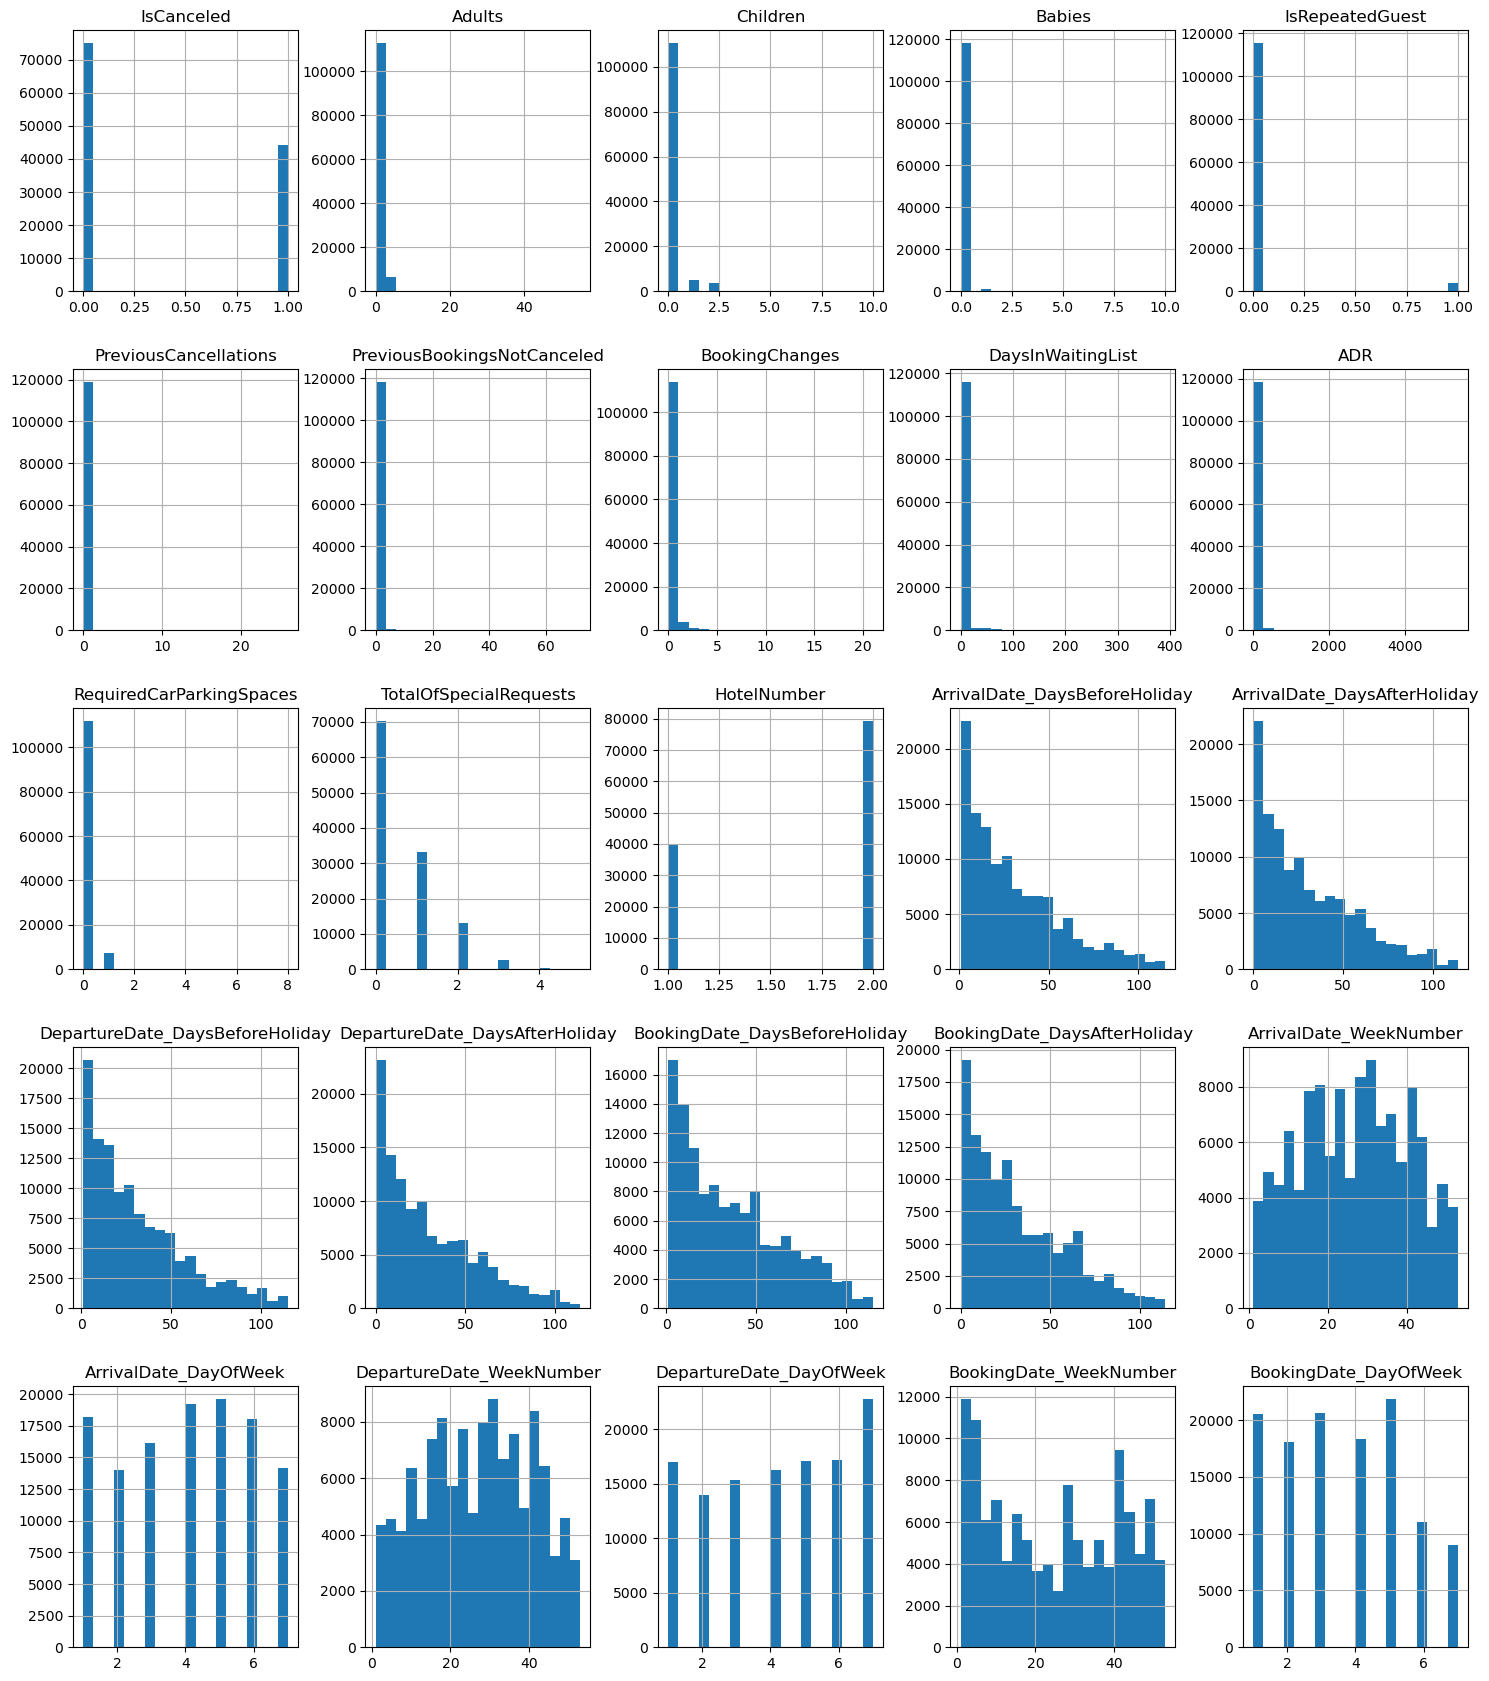

In [37]:
data[data_number].hist(bins = 20, figsize = (18,21), layout = (-1, 5));

### Non-Numeric

In [38]:
vc_params = {'normalize':True, 'dropna': False, 'ascending': False}

for col in data_non_num:
    if data[col].nunique() < 10:
        print(data[col].value_counts(**vc_params),'\n')
    else:
        print(data[col].value_counts(**vc_params)[:5], '\n')

Meal
BB          0.77
HB          0.12
SC          0.09
Undefined   0.01
FB          0.01
Name: proportion, dtype: float64 

Country
PRT   0.41
GBR   0.10
FRA   0.09
ESP   0.07
DEU   0.06
Name: proportion, dtype: float64 

MarketSegment
Online TA       0.47
Offline TA/TO   0.20
Groups          0.17
Direct          0.11
Corporate       0.04
Complementary   0.01
Aviation        0.00
Undefined       0.00
Name: proportion, dtype: float64 

DistributionChannel
TA/TO       0.82
Direct      0.12
Corporate   0.06
GDS         0.00
Undefined   0.00
Name: proportion, dtype: float64 

ReservedRoomType
A                  0.72
D                  0.16
E                  0.05
F                  0.02
G                  0.02
Name: proportion, dtype: float64 

AssignedRoomType
A                  0.62
D                  0.21
E                  0.07
F                  0.03
G                  0.02
Name: proportion, dtype: float64 

DepositType
No Deposit        0.88
Non Refund        0.12
Refundable        

---

Rare-Label Encoding for categories <5%. Binary encoding for features w/ low variance.

---

# Drop ReservationStatus

---

> `ReservationStatus` is nearly identical to my target feature and would be too strong of a predictor in my models.

---

In [40]:
data[['ReservationStatus', 'IsCanceled']].value_counts()

ReservationStatus  IsCanceled
Check-Out          0             75166
Canceled           1             43017
No-Show            1              1207
Name: count, dtype: int64

In [20]:
## Dropping "reservation_status"
data.drop(columns = 'ReservationStatus', inplace=True)

In [20]:
## Confirming 'reservation_status' removal from dataframe
'ReservationStatus' not in data

True

#  **Post-EDA Updates**

1. Outliers (continuous features): [OutlierTrimmer using MAD](https://feature-engine.trainindata.com/en/latest/user_guide/outliers/OutlierTrimmer.html#maximum-absolute-deviation)
2. Categorical encoding: [DecisionTreeEncoder](https://feature-engine.trainindata.com/en/latest/api_doc/encoding/DecisionTreeEncoder.html#decisiontreeencoder)
3. Rare labels (categoricals): [RareLabelEncoding](https://feature-engine.trainindata.com/en/latest/api_doc/encoding/RareLabelEncoder.html#rarelabelencoder)
4. Datetime-related features: Review [DatetimeFeatures](https://feature-engine.trainindata.com/en/latest/user_guide/datetime/DatetimeFeatures.html#automating-feature-extraction)

In [23]:
data.head().T

,0,1,2,3,4
IsCanceled,0,0,0,0,0
Adults,2,2,1,1,2
Children,0.00,0.00,0.00,0.00,0.00
Babies,0,0,0,0,0
Meal,BB,BB,BB,BB,BB
Country,PRT,PRT,GBR,GBR,GBR
MarketSegment,Direct,Direct,Direct,Corporate,Online TA
DistributionChannel,Direct,Direct,Direct,Corporate,TA/TO
IsRepeatedGuest,0,0,0,0,0
PreviousCancellations,0,0,0,0,0


## Test Missing Value Imputation

In [32]:
data.isna().sum()[data.isna().sum() > 0]

Children      4
Country     488
dtype: int64

In [ ]:
from feature_engine.imputation import CategoricalImputer, MeanMedianImputer

cat_imputer = CategoricalImputer(variables=['Country'], imputation_method = 'frequent')

data_imputed = cat_imputer.fit_transform(data)

num_imputer = MeanMedianImputer(imputation_method = 'median', variables = ['Children'])

data_imputed = num_imputer.fit_transform(data_imputed)

data_imputed.isna().sum().sum()

## Test Categorical Encoder

# Preserving the Pandas (DataFrame)

---

Now I am ready to save the cleaned and processed data for modeling in my next notebook.

---

In [22]:
# ## Pickling with Pandas
# data.to_pickle(path = '../data/data_prepped.pickle',
#             compression = 'gzip')
# print(f'Successfully pickled!')

In [23]:
## Pickling with Pandas
data.to_parquet(path = '../data/data_prepped.parquet')
print(f'Successfully saved!')

Successfully saved!


# Future Work: EDA

---

In the future, I will revisit the visualization aspects of my EDA function to convert them from Plotly Express figures to Matplotlib figures. The goal with Plotly Express was to have additional interativity; however these models crippled my notebook's operations. Matplotlib figures would be more appropriate in this case, and I will revisit this work when I have more time.

---


# Moving to Modeling!

---

> Now that I completed the pre-processing and EDA steps, I will move to my next notebook to perform my classification modeling.

---